In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.25,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_025_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:16 - loss: 0.0966 - STD: 1.6681e-04 - MAE: 0.2952

 11/632 [..............................] - ETA: 3s - loss: 0.0299 - STD: 1.6536e-04 - MAE: 0.1364   

 19/632 [..............................] - ETA: 3s - loss: 0.0244 - STD: 1.2662e-04 - MAE: 0.1192

 27/632 [>.............................] - ETA: 3s - loss: 0.0207 - STD: 1.2483e-04 - MAE: 0.1113

 36/632 [>.............................] - ETA: 3s - loss: 0.0181 - STD: 1.2215e-04 - MAE: 0.1029

 45/632 [=>............................] - ETA: 3s - loss: 0.0166 - STD: 1.2615e-04 - MAE: 0.0980

 54/632 [=>............................] - ETA: 3s - loss: 0.0155 - STD: 1.3627e-04 - MAE: 0.0951

 63/632 [=>............................] - ETA: 3s - loss: 0.0148 - STD: 1.4951e-04 - MAE: 0.0927

 72/632 [==>...........................] - ETA: 3s - loss: 0.0142 - STD: 1.6918e-04 - MAE: 0.0909

 81/632 [==>...........................] - ETA: 3s - loss: 0.0137 - STD: 1.9466e-04 - MAE: 0.0895

 90/632 [===>..........................] - ETA: 3s - loss: 0.0133 - STD: 2.2757e-04 - MAE: 0.0884

 99/632 [===>..........................] - ETA: 3s - loss: 0.0130 - STD: 2.7093e-04 - MAE: 0.0873

108/632 [====>.........................] - ETA: 3s - loss: 0.0127 - STD: 3.2860e-04 - MAE: 0.0865

117/632 [====>.........................] - ETA: 3s - loss: 0.0125 - STD: 4.0867e-04 - MAE: 0.0857

126/632 [====>.........................] - ETA: 3s - loss: 0.0123 - STD: 5.2170e-04 - MAE: 0.0851

135/632 [=====>........................] - ETA: 2s - loss: 0.0121 - STD: 6.8562e-04 - MAE: 0.0845

144/632 [=====>........................] - ETA: 2s - loss: 0.0119 - STD: 9.2816e-04 - MAE: 0.0840

153/632 [======>.......................] - ETA: 2s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0835    

162/632 [======>.......................] - ETA: 2s - loss: 0.0116 - STD: 0.0019 - MAE: 0.0830

171/632 [=======>......................] - ETA: 2s - loss: 0.0115 - STD: 0.0027 - MAE: 0.0825

180/632 [=======>......................] - ETA: 2s - loss: 0.0113 - STD: 0.0038 - MAE: 0.0821

183/632 [=======>......................] - ETA: 3s - loss: 0.0113 - STD: 0.0043 - MAE: 0.0819

194/632 [========>.....................] - ETA: 3s - loss: 0.0111 - STD: 0.0058 - MAE: 0.0813

203/632 [========>.....................] - ETA: 3s - loss: 0.0110 - STD: 0.0072 - MAE: 0.0808

212/632 [=========>....................] - ETA: 3s - loss: 0.0108 - STD: 0.0086 - MAE: 0.0803

221/632 [=========>....................] - ETA: 3s - loss: 0.0107 - STD: 0.0098 - MAE: 0.0798

230/632 [=========>....................] - ETA: 3s - loss: 0.0106 - STD: 0.0110 - MAE: 0.0794

239/632 [==========>...................] - ETA: 3s - loss: 0.0105 - STD: 0.0122 - MAE: 0.0789

248/632 [==========>...................] - ETA: 2s - loss: 0.0104 - STD: 0.0133 - MAE: 0.0785

257/632 [===========>..................] - ETA: 2s - loss: 0.0103 - STD: 0.0144 - MAE: 0.0780

266/632 [===========>..................] - ETA: 2s - loss: 0.0102 - STD: 0.0155 - MAE: 0.0774

275/632 [============>.................] - ETA: 2s - loss: 0.0100 - STD: 0.0167 - MAE: 0.0769

284/632 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 0.0180 - MAE: 0.0764

293/632 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 0.0192 - MAE: 0.0759

302/632 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0203 - MAE: 0.0754

311/632 [=============>................] - ETA: 2s - loss: 0.0096 - STD: 0.0214 - MAE: 0.0749

320/632 [==============>...............] - ETA: 2s - loss: 0.0095 - STD: 0.0225 - MAE: 0.0744

329/632 [==============>...............] - ETA: 2s - loss: 0.0094 - STD: 0.0235 - MAE: 0.0739

338/632 [===============>..............] - ETA: 2s - loss: 0.0093 - STD: 0.0246 - MAE: 0.0735

347/632 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 0.0255 - MAE: 0.0730

354/632 [===============>..............] - ETA: 2s - loss: 0.0091 - STD: 0.0263 - MAE: 0.0727

363/632 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.0272 - MAE: 0.0722

372/632 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.0281 - MAE: 0.0718

380/632 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0288 - MAE: 0.0714

389/632 [=================>............] - ETA: 1s - loss: 0.0088 - STD: 0.0296 - MAE: 0.0711

398/632 [=================>............] - ETA: 1s - loss: 0.0087 - STD: 0.0303 - MAE: 0.0707

407/632 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0311 - MAE: 0.0704

416/632 [==================>...........] - ETA: 1s - loss: 0.0086 - STD: 0.0318 - MAE: 0.0700

424/632 [===================>..........] - ETA: 1s - loss: 0.0085 - STD: 0.0325 - MAE: 0.0697

433/632 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0332 - MAE: 0.0693

442/632 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0339 - MAE: 0.0690

451/632 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0345 - MAE: 0.0687

460/632 [====================>.........] - ETA: 1s - loss: 0.0082 - STD: 0.0352 - MAE: 0.0684

469/632 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0359 - MAE: 0.0681

478/632 [=====================>........] - ETA: 1s - loss: 0.0081 - STD: 0.0365 - MAE: 0.0677

487/632 [======================>.......] - ETA: 1s - loss: 0.0080 - STD: 0.0371 - MAE: 0.0674

496/632 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0377 - MAE: 0.0672

505/632 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0382 - MAE: 0.0670

514/632 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0386 - MAE: 0.0668

523/632 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0391 - MAE: 0.0665

532/632 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0396 - MAE: 0.0663

541/632 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0402 - MAE: 0.0660

550/632 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0406 - MAE: 0.0658

559/632 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0411 - MAE: 0.0655

568/632 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.0416 - MAE: 0.0653

577/632 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0420 - MAE: 0.0651

586/632 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0424 - MAE: 0.0648

595/632 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0428 - MAE: 0.0646

604/632 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.0432 - MAE: 0.0644

613/632 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0437 - MAE: 0.0642

622/632 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0440 - MAE: 0.0640

631/632 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0444 - MAE: 0.0638

632/632 [==============================] - 6s 8ms/step - loss: 0.0073 - STD: 0.0445 - MAE: 0.0638 - val_loss: 0.0045 - val_STD: 0.0522 - val_MAE: 0.0484


Epoch 2/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0495

  7/632 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0722 - MAE: 0.0514 

 16/632 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0706 - MAE: 0.0517

 25/632 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0515

 34/632 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0511

 42/632 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0508

 51/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0506

 59/632 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0504

 68/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0505

 77/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0507

 86/632 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

 95/632 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0506

104/632 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0506

113/632 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0505

122/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0504

131/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0504

140/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

149/632 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0503

158/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0503

167/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0503

176/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502

185/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0502

194/632 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

203/632 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

212/632 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

221/632 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

230/632 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0501

239/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

248/632 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0501

257/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0500

265/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

274/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

283/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

292/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

301/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

310/632 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

319/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

328/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

337/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

346/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

355/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

364/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

373/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

382/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

391/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

400/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

409/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

418/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

427/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

436/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

445/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

454/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0496

463/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

472/632 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

481/632 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0495

490/632 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0495

499/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0495

508/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

517/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

526/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

535/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

544/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

553/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

561/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

570/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

579/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

588/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

596/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

605/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

613/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

621/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

630/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

632/632 [==============================] - 4s 7ms/step - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491 - val_loss: 0.0038 - val_STD: 0.0614 - val_MAE: 0.0461


Epoch 3/10000


  1/632 [..............................] - ETA: 24s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0499

  7/632 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0479 

 14/632 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

 23/632 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

 31/632 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

 40/632 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0477

 49/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0481

 58/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

 67/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

 76/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0480

 85/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0480

 94/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

103/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

112/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0480

121/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0479

130/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

139/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477

148/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477

157/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

166/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

175/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

184/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0476

192/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0477

200/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476

209/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

218/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

227/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

236/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

245/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

253/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

262/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

270/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

279/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

287/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

296/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

305/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

314/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

323/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

332/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

341/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

350/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

359/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

368/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

377/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

386/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

395/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

404/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

413/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

422/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

431/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0471

440/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

449/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

458/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

467/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0470

476/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

485/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

494/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

503/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

512/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

521/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

530/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468

539/632 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

548/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

557/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

566/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

575/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

584/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

593/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

602/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467

611/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

620/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

629/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468

632/632 [==============================] - 4s 6ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0468 - val_loss: 0.0035 - val_STD: 0.0613 - val_MAE: 0.0439


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

  9/632 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457 

 18/632 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0455

 27/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

 36/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

 45/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

 54/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

 63/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

 71/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

 79/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

 88/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

 97/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454

105/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0455

114/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

123/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

131/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

140/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

149/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

158/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

167/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457

176/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

184/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0458

193/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0458

202/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

211/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

220/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

229/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

238/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

247/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

256/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

265/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

274/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

283/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

292/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

301/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

310/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

319/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

328/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

337/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

346/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

355/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

363/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

372/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

381/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

390/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

399/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

408/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

416/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

425/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

433/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

442/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

451/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

460/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

469/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

478/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

487/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

496/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

505/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

514/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

523/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

532/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

541/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

550/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

559/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

568/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

577/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

586/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

595/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

604/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

614/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

623/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

631/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

632/632 [==============================] - 4s 6ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456 - val_loss: 0.0037 - val_STD: 0.0645 - val_MAE: 0.0455


Epoch 5/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0810 - MAE: 0.0468

 10/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0783 - MAE: 0.0467 

 18/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0784 - MAE: 0.0461

 27/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

 36/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0453

 45/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452

 53/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

 62/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451

 71/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0451

 80/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

 89/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450

 98/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449

107/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

116/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449

125/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

134/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

143/632 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

152/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

161/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

170/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

179/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

188/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

197/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

206/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

215/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448

224/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

233/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

242/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

251/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

260/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

269/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

278/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

287/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

296/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

305/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

314/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

323/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

332/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

341/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

350/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

359/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

368/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

377/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

386/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

395/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

404/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

413/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

422/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

431/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

440/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

449/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

458/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

467/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

476/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

485/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

494/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

503/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

512/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

521/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

530/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

539/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

548/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

557/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

566/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

575/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

584/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

593/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

602/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

611/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

620/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

629/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

632/632 [==============================] - 4s 6ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447 - val_loss: 0.0044 - val_STD: 0.0696 - val_MAE: 0.0506


Epoch 6/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0042 - STD: 0.0807 - MAE: 0.0487

  7/632 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0447 

 15/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

 24/632 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0449

 33/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 42/632 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

 51/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 60/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

 69/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

 78/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

 87/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444

 95/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

104/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

113/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

122/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

131/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

139/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

148/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

157/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

166/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

175/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

184/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

192/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

201/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

210/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

219/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

228/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

237/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

246/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

255/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

264/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

273/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

282/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

291/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

300/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

309/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

318/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

327/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

336/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

345/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

354/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

363/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

372/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

381/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

389/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

398/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

407/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

416/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

424/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

433/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

442/632 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

451/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

460/632 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443

468/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

477/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

486/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

494/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

503/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

512/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

521/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

530/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

539/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

547/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

556/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

565/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

574/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

583/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

592/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

600/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

609/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

618/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

627/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

632/632 [==============================] - 4s 6ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441 - val_loss: 0.0038 - val_STD: 0.0676 - val_MAE: 0.0461


Epoch 7/10000


  1/632 [..............................] - ETA: 20s - loss: 0.0033 - STD: 0.0840 - MAE: 0.0434

  7/632 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0822 - MAE: 0.0430 

 15/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0431

 24/632 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

 32/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0436

 41/632 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 50/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 58/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

 65/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

 72/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

 81/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

 90/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

 99/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

108/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

117/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

126/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

135/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

144/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

153/632 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

162/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

170/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

178/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

187/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

196/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

205/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

214/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

223/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

232/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0437

241/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

250/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

259/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

268/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

277/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

286/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

295/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

304/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

313/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

321/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

330/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

339/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

347/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

356/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

365/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

374/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

382/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

391/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

400/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

409/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

418/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

427/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

436/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

445/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

454/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

463/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

472/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

481/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

490/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

499/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

508/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

517/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

526/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

535/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

544/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

553/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

562/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

571/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

579/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

588/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

597/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

606/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

615/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

624/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434 - val_loss: 0.0036 - val_STD: 0.0621 - val_MAE: 0.0433


Epoch 8/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0036 - STD: 0.0771 - MAE: 0.0424

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0433 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0431

 27/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0428

 36/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

 44/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0430

 52/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0434

 60/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 69/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

 77/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

 85/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 94/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

103/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

112/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

121/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

130/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

139/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

148/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

157/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

166/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

175/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

184/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

193/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

202/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

211/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

220/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

229/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

238/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

247/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

256/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

265/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

274/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0434

283/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

292/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

301/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

310/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

319/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

328/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

337/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

346/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

355/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

364/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

373/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

382/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

391/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

400/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

409/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

418/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

427/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

436/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

445/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

454/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

462/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

469/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

477/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

486/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

495/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

504/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

513/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

521/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

530/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

539/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

548/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

557/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

565/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

574/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

583/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

592/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

601/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

610/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

619/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

628/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432 - val_loss: 0.0036 - val_STD: 0.0657 - val_MAE: 0.0446


Epoch 9/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0039 - STD: 0.0873 - MAE: 0.0461

 10/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0436 

 19/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0434

 28/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0435

 37/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

 46/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

 55/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

 64/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

 73/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

 82/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

 91/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0428

100/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0428

109/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

118/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

127/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

136/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

145/632 [=====>........................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

154/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

163/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

172/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

181/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

190/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

199/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

208/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

217/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

226/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

235/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

244/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

253/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

262/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

271/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

280/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

289/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

298/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0426

307/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

316/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

325/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

333/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

341/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0425

350/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

359/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

367/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

376/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

385/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

394/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

403/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

411/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

419/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

428/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

437/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

446/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

455/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

464/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

473/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

482/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

491/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

500/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

509/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

518/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

527/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

536/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

545/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

554/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

563/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

572/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

581/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0425

590/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

599/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

608/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

617/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

626/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425 - val_loss: 0.0035 - val_STD: 0.0668 - val_MAE: 0.0436


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0033 - STD: 0.0790 - MAE: 0.0423

 10/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0419 

 19/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0418

 28/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0415

 37/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0416

 46/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0415

 55/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

 64/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0811 - MAE: 0.0417

 73/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0417

 82/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

 91/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

100/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

109/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

118/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

127/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

136/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

145/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

153/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

162/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

171/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0417

180/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0417

189/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0417

197/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0417

206/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

215/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

224/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

233/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

242/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

250/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

259/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

267/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

276/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

285/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

294/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

303/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

312/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

321/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

330/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

339/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

348/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

357/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

366/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

375/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

384/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

393/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

402/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

411/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

420/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

429/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

438/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

446/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

454/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

462/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

471/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

480/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

489/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

498/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

507/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

516/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

525/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

534/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

542/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

550/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

558/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

567/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

576/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

585/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

594/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

603/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

611/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

619/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

628/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421 - val_loss: 0.0040 - val_STD: 0.0538 - val_MAE: 0.0444


Epoch 11/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0040 - STD: 0.0655 - MAE: 0.0460

  7/632 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0445 

 14/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0436

 22/632 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

 31/632 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0429

 40/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

 49/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

 58/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

 67/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

 76/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

 85/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

 94/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

103/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

112/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

121/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

130/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

139/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

148/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

157/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

166/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

174/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

183/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

192/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

201/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

210/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

219/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

228/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

237/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

246/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

255/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

264/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

273/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

282/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

291/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

300/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

309/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

318/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

327/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

336/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

345/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

354/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

363/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

372/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

381/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

390/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

399/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

408/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

417/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

426/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0417

435/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

444/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0417

453/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

462/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

471/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

480/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

489/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

498/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

507/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

516/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

525/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

534/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

543/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

552/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

561/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

570/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

579/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

588/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

597/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

606/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

615/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

624/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417 - val_loss: 0.0036 - val_STD: 0.0609 - val_MAE: 0.0426


Epoch 12/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0030 - STD: 0.0742 - MAE: 0.0404

  8/632 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0803 - MAE: 0.0408 

 16/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0409

 25/632 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0410

 34/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

 43/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0413

 52/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0416

 61/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

 70/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0420

 79/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

 88/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0420

 97/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0421

106/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0420

115/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

124/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

133/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

142/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

150/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

159/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

168/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

177/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

186/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

195/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

204/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

213/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

222/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

231/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

239/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

247/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

256/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

265/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

274/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

283/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

292/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

301/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

310/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

319/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

327/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

336/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

345/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

354/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

363/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

372/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0415

381/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

390/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

398/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

406/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

415/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

424/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

433/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

442/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

451/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0416

460/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

469/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

478/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

487/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

496/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

505/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

514/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

523/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

532/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

541/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

550/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

559/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

568/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

576/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

585/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

594/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0415

603/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

612/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

621/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

630/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414 - val_loss: 0.0035 - val_STD: 0.0624 - val_MAE: 0.0422


Epoch 13/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0416

  7/632 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0401 

 16/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0406

 25/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

 34/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

 42/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

 50/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0818 - MAE: 0.0407

 59/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

 68/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

 77/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0406

 86/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0406

 94/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

102/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0406

110/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

119/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

128/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0406

137/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0405

146/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0406

155/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

163/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

171/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

179/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

188/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0407

196/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

203/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0407

211/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

220/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

229/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

238/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

247/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

256/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

265/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

274/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

283/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

292/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

301/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

310/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

319/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

328/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

337/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

346/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

355/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

364/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

373/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

382/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

391/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

400/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0408

407/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

416/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

425/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

433/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

442/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

451/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

460/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

468/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

476/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

485/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0408

493/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

502/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

511/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0408

520/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

529/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

538/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

547/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

556/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

565/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

574/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

583/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

591/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

599/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

608/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

617/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

625/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

632/632 [==============================] - 4s 7ms/step - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408 - val_loss: 0.0035 - val_STD: 0.0649 - val_MAE: 0.0425


Epoch 14/10000


  1/632 [..............................] - ETA: 17s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0383

  8/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0395 

 14/632 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0400

 22/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0402

 31/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0406

 39/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

 48/632 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

 56/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

 65/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

 74/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

 83/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

 92/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

101/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

110/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

119/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

128/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

137/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

146/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

155/632 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

163/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

172/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

181/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

190/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

199/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

208/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

217/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

226/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

235/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

244/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

253/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0404

262/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

271/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

280/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

289/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

298/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0405

307/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

316/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

325/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0406

334/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0406

343/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

352/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

361/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

370/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

379/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

388/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

397/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

406/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

415/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

424/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

432/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

441/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

450/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

458/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

467/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

475/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

483/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

492/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

500/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

509/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

517/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

526/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

535/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

544/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

553/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

562/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

571/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

580/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

589/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

598/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

607/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

616/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0405

625/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

632/632 [==============================] - 4s 7ms/step - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404 - val_loss: 0.0034 - val_STD: 0.0642 - val_MAE: 0.0424


Epoch 15/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0396

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0817 - MAE: 0.0390 

 18/632 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0825 - MAE: 0.0393

 27/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

 36/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0397

 45/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

 54/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

 63/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

 72/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

 81/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

 89/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0403

 98/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

107/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

116/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

125/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

134/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

143/632 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

152/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

161/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

170/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

179/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

188/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

197/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

205/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0404

214/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

223/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

231/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

240/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

249/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

258/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

267/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

276/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

285/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

294/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

303/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

311/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

320/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

328/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

337/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

346/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

355/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

364/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

373/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

382/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

391/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

400/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

409/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

418/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

427/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

436/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

445/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

454/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

463/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

472/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

481/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

490/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

499/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

508/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

517/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

525/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

534/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

543/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

552/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

561/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

570/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

579/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

588/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

597/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

606/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

615/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

624/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

632/632 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403 - val_loss: 0.0038 - val_STD: 0.0586 - val_MAE: 0.0436


Epoch 16/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0755 - MAE: 0.0407

  8/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0421 

 17/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0406

 26/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0402

 35/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0400

 44/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0399

 53/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 62/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 71/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0399

 80/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

 89/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 98/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0400

107/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

116/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

124/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

131/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

140/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0398

149/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

158/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

167/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

175/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

184/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

193/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

202/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

211/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

220/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

229/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

237/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

246/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

255/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

264/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

273/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

282/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

291/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

300/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

309/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

318/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

327/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

336/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

344/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

353/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

362/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

371/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

380/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

389/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

398/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

407/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

416/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

425/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

434/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

443/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

452/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

461/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

470/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

479/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

488/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

497/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

506/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

515/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

524/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

533/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

542/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

551/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

560/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

569/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

578/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

587/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

596/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

605/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

614/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

623/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

632/632 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400 - val_loss: 0.0035 - val_STD: 0.0674 - val_MAE: 0.0428


Epoch 17/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0036 - STD: 0.0889 - MAE: 0.0416

  7/632 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0820 - MAE: 0.0403 

 15/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0836 - MAE: 0.0396

 24/632 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0397

 31/632 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

 40/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

 49/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0401

 58/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

 67/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

 75/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

 84/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0402

 93/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

101/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

109/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

118/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

127/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

136/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

145/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

154/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

163/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

172/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

181/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

190/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

199/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

208/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

217/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

226/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

235/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

244/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

253/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

262/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

271/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

280/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

289/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

298/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

307/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

316/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

325/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

334/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

343/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

352/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

361/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

369/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

378/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

387/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

396/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

405/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

414/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

423/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

432/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

441/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

450/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

458/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

467/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

476/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

485/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

494/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

503/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

512/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

521/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

530/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

539/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

548/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0396

557/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

566/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

575/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

584/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

593/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

602/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

611/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

620/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

629/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0396

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0828 - MAE: 0.0396 - val_loss: 0.0041 - val_STD: 0.0739 - val_MAE: 0.0475


Epoch 18/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0897 - MAE: 0.0433

  9/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0804 - MAE: 0.0400 

 18/632 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0830 - MAE: 0.0389

 27/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

 36/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

 45/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0835 - MAE: 0.0391

 54/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0392

 63/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0833 - MAE: 0.0394

 72/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0394

 81/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0831 - MAE: 0.0393

 90/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

 99/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0830 - MAE: 0.0394

108/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0394

117/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

126/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

135/632 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

144/632 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

153/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0393

162/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

171/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

180/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

189/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

198/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

207/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

216/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0394

225/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

234/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

243/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

252/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0396

261/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

270/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

279/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

288/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

297/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0394

306/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0394

315/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

324/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

333/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

342/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

351/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

360/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

369/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

378/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

387/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

396/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

405/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

414/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

423/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0394

432/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0394

441/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

450/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

459/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

468/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

477/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

486/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

495/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

503/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

512/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

521/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

530/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

539/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

548/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

557/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

566/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

575/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

584/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

593/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

602/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

611/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

620/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

628/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

632/632 [==============================] - 4s 6ms/step - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394 - val_loss: 0.0035 - val_STD: 0.0652 - val_MAE: 0.0424


Epoch 19/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0027 - STD: 0.0834 - MAE: 0.0380

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0824 - MAE: 0.0391 

 17/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0817 - MAE: 0.0398

 26/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0813 - MAE: 0.0403

 35/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0809 - MAE: 0.0405

 43/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0405

 52/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0812 - MAE: 0.0402

 61/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0400

 70/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0400

 79/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0399

 88/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

 97/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0398

106/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0397

115/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

124/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0397

133/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0396

142/632 [=====>........................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0396

151/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0396

160/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0396

169/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

177/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0395

186/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0395

193/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0395

201/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0395

210/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

219/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

228/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0827 - MAE: 0.0395

237/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0395

246/632 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0395

255/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

265/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

274/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0394

283/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

292/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0393

301/632 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0393

310/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

319/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

328/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

337/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

346/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

355/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

364/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

373/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

382/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

391/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

400/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

409/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0392

418/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

427/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

436/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

445/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

454/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

463/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

472/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

481/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

490/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

498/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

507/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

516/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

525/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

534/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

543/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

552/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

561/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

570/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

579/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

588/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

597/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

605/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

614/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0392

623/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0392

632/632 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0392

632/632 [==============================] - 4s 6ms/step - loss: 0.0029 - STD: 0.0831 - MAE: 0.0392 - val_loss: 0.0036 - val_STD: 0.0675 - val_MAE: 0.0442


Epoch 20/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0031 - STD: 0.0874 - MAE: 0.0405

  9/632 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393 

 17/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0397

 25/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

 33/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0393

 42/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0391

 51/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0826 - MAE: 0.0390

 60/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0390

 69/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0389

 78/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0389

 87/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0389

 96/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0389

105/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

114/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0391

123/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0391

132/632 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0390

141/632 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0390

150/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0390

159/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0389

168/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0390

177/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0390

186/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

195/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

204/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

213/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

222/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

231/632 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

240/632 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

249/632 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0390

258/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

267/632 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

276/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

285/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

293/632 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0391

302/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

311/632 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

320/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

329/632 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

338/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

347/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

356/632 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0390

365/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

374/632 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0390

383/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0390

392/632 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

401/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0389

410/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

419/632 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

428/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

437/632 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

446/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

455/632 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

464/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

473/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

482/632 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

491/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

500/632 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

509/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

518/632 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

527/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0389

536/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

545/632 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

554/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

563/632 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

572/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

581/632 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

590/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

599/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0389

608/632 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0389

617/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

626/632 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0389

632/632 [==============================] - 4s 6ms/step - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389 - val_loss: 0.0036 - val_STD: 0.0699 - val_MAE: 0.0429


Epoch 21/10000


  1/632 [..............................] - ETA: 19s - loss: 0.0029 - STD: 0.0875 - MAE: 0.0394

  9/632 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0843 - MAE: 0.0390 

 18/632 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0834 - MAE: 0.0389

 26/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0390

 35/632 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0832 - MAE: 0.0392

 44/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0394

 53/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0395

 61/632 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0394

 70/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0393

 79/632 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0392

 88/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0391

 97/632 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0830 - MAE: 0.0391

106/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0831 - MAE: 0.0390

115/632 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0389

124/632 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0833 - MAE: 0.0389

133/632 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0833 - MAE: 0.0388

142/632 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0833 - MAE: 0.0388

151/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0388

160/632 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

169/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0389

178/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

187/632 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0833 - MAE: 0.0389

196/632 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0834 - MAE: 0.0388

205/632 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0834 - MAE: 0.0388

214/632 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0834 - MAE: 0.0388

223/632 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0834 - MAE: 0.0388

232/632 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0388

241/632 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0388

250/632 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0388

259/632 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0387

268/632 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0387

277/632 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0387

286/632 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0835 - MAE: 0.0387

295/632 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0387

304/632 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0387

313/632 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0387

322/632 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

331/632 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

340/632 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

349/632 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

358/632 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

367/632 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

376/632 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

385/632 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

394/632 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

403/632 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

412/632 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

421/632 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

430/632 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

439/632 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

448/632 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

457/632 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

466/632 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

475/632 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

484/632 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

493/632 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

502/632 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

511/632 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

520/632 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

529/632 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

538/632 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

547/632 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

556/632 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

565/632 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

574/632 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

583/632 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0386

592/632 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

601/632 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

610/632 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

619/632 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

628/632 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386

632/632 [==============================] - 4s 6ms/step - loss: 0.0028 - STD: 0.0836 - MAE: 0.0386 - val_loss: 0.0036 - val_STD: 0.0700 - val_MAE: 0.0431


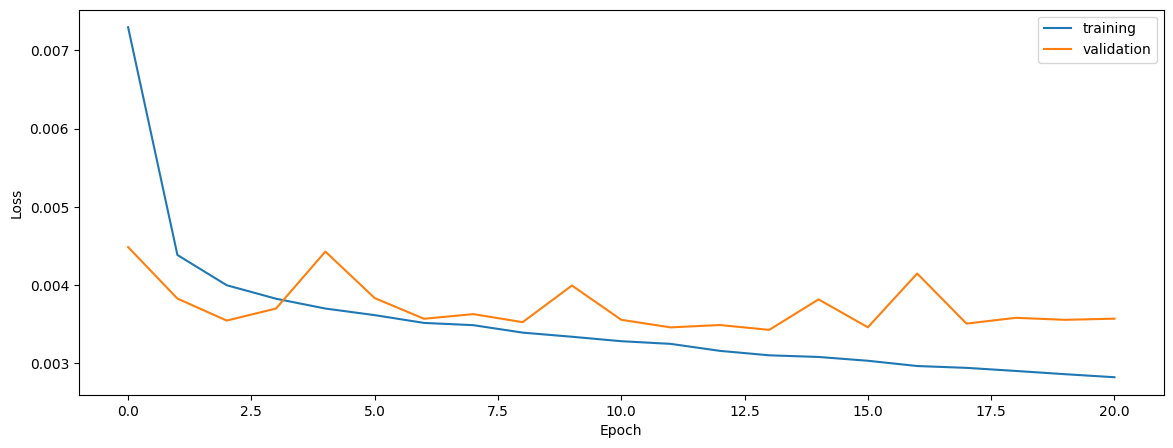

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8368918543428732
0.7978065881417287
0.8106331174135488


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8368918543428732
0.7978065881417287
0.8106331174135488


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.840147138143307
0.7997911049142099
0.8175335141505438


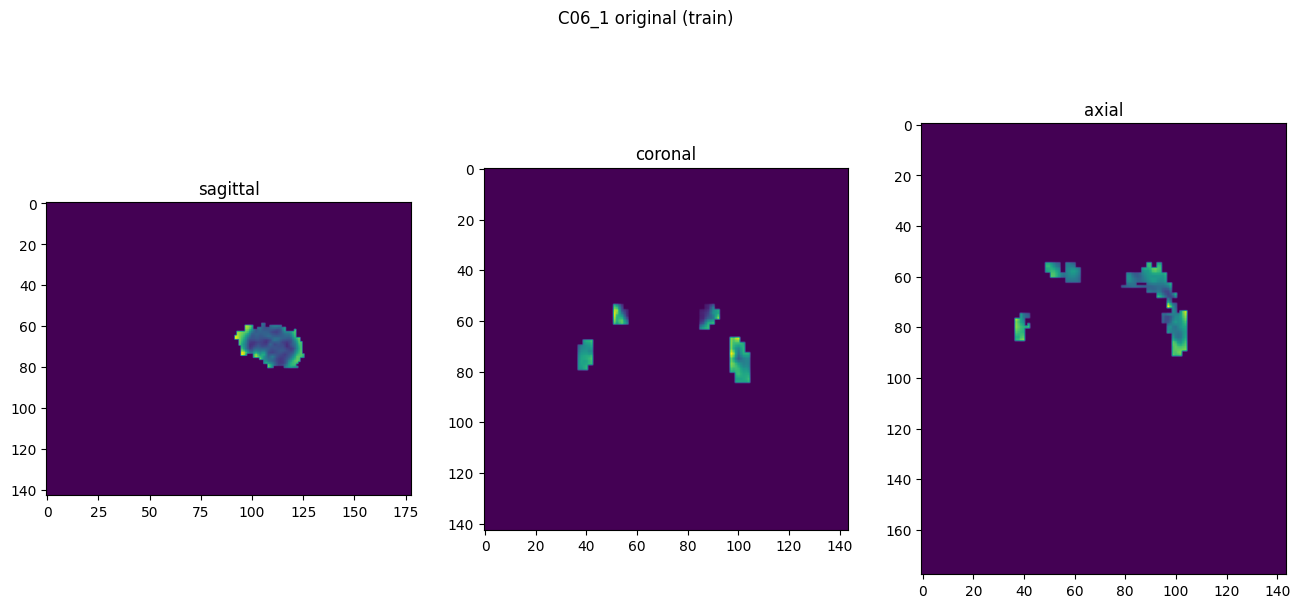

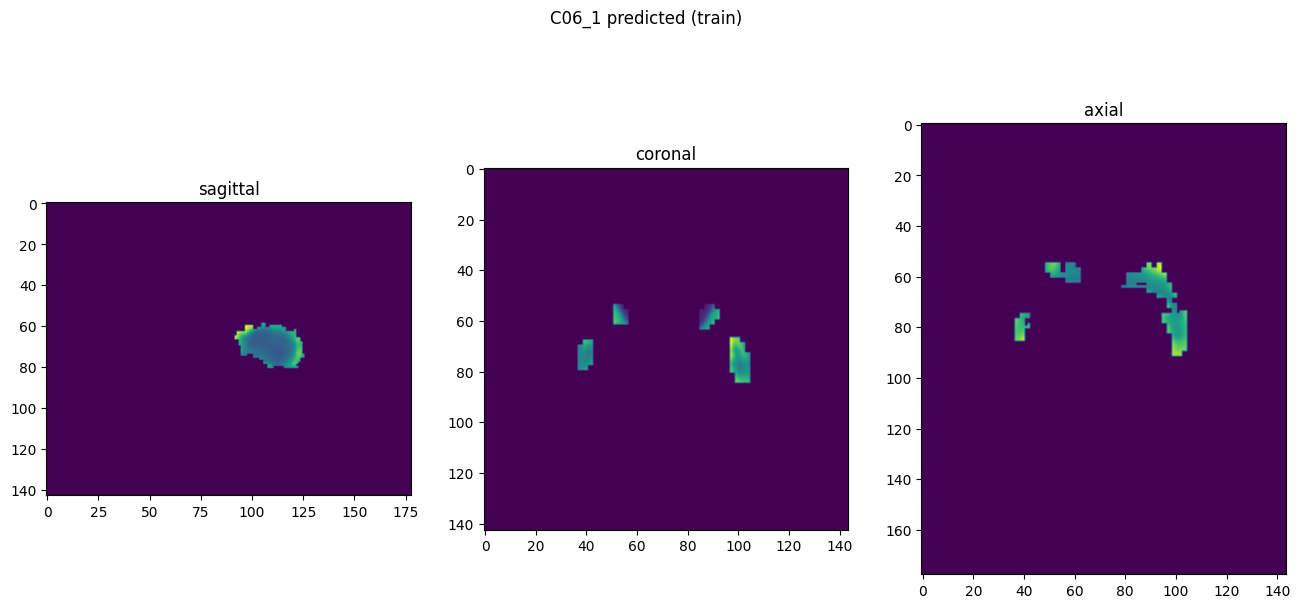

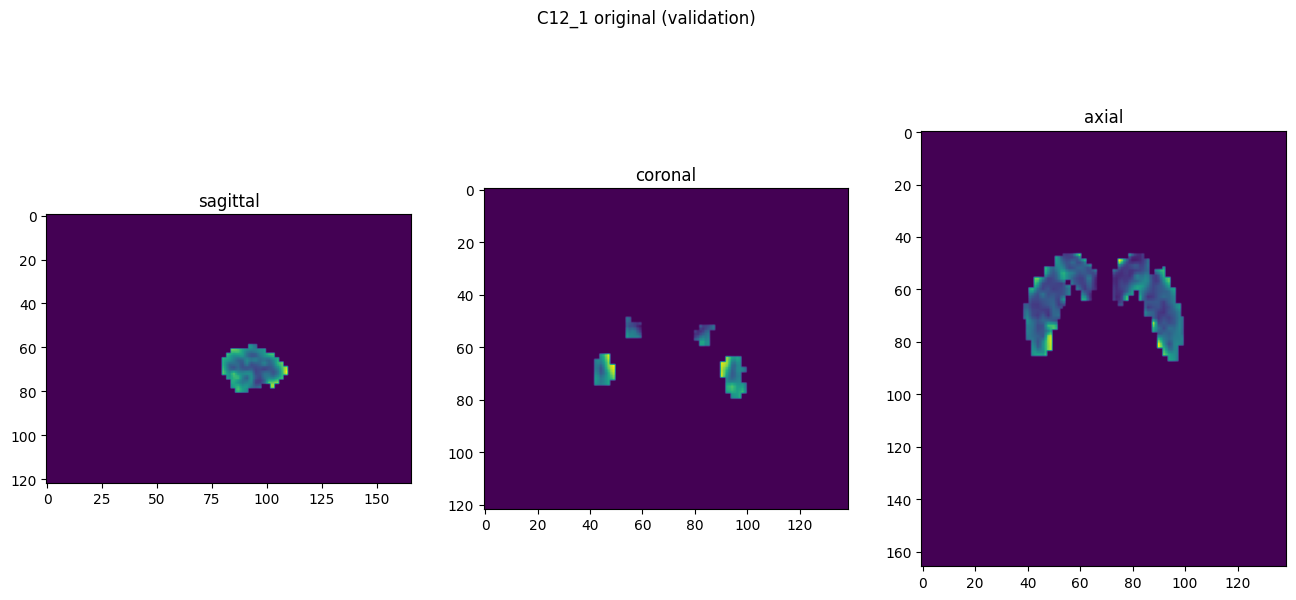

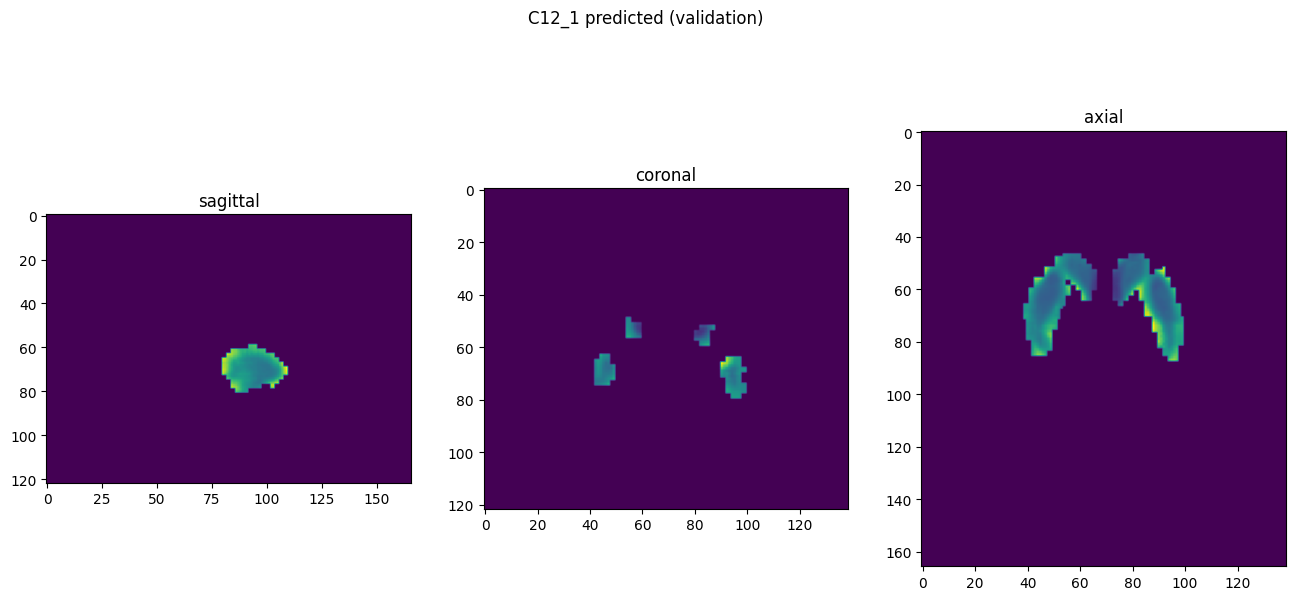

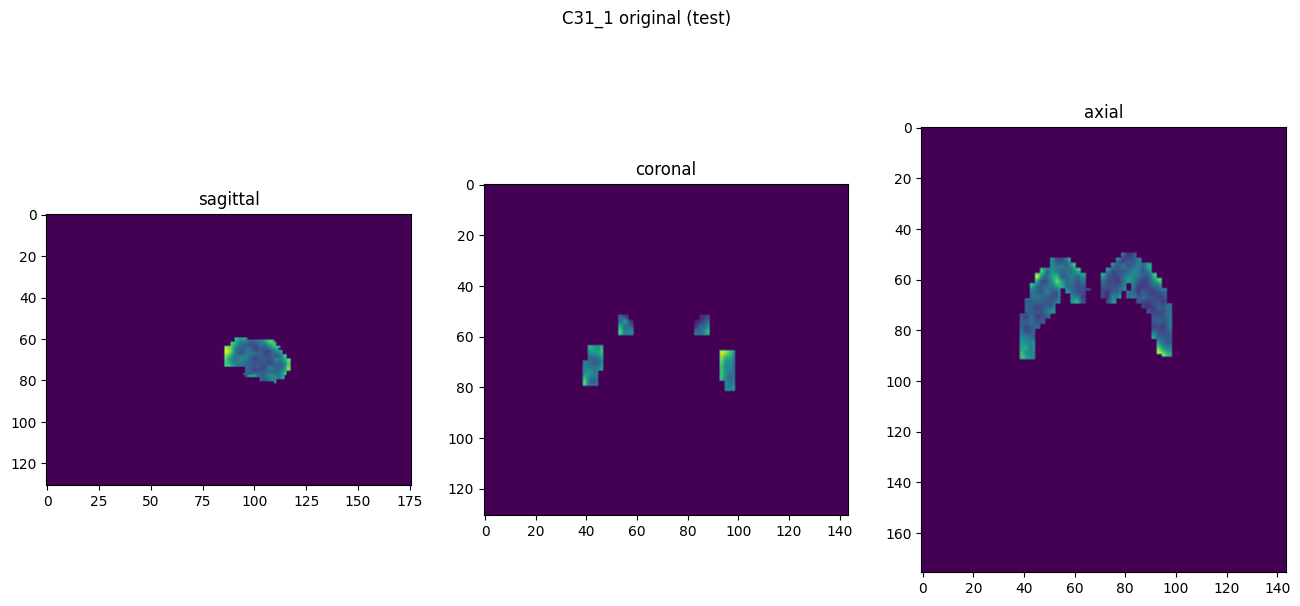

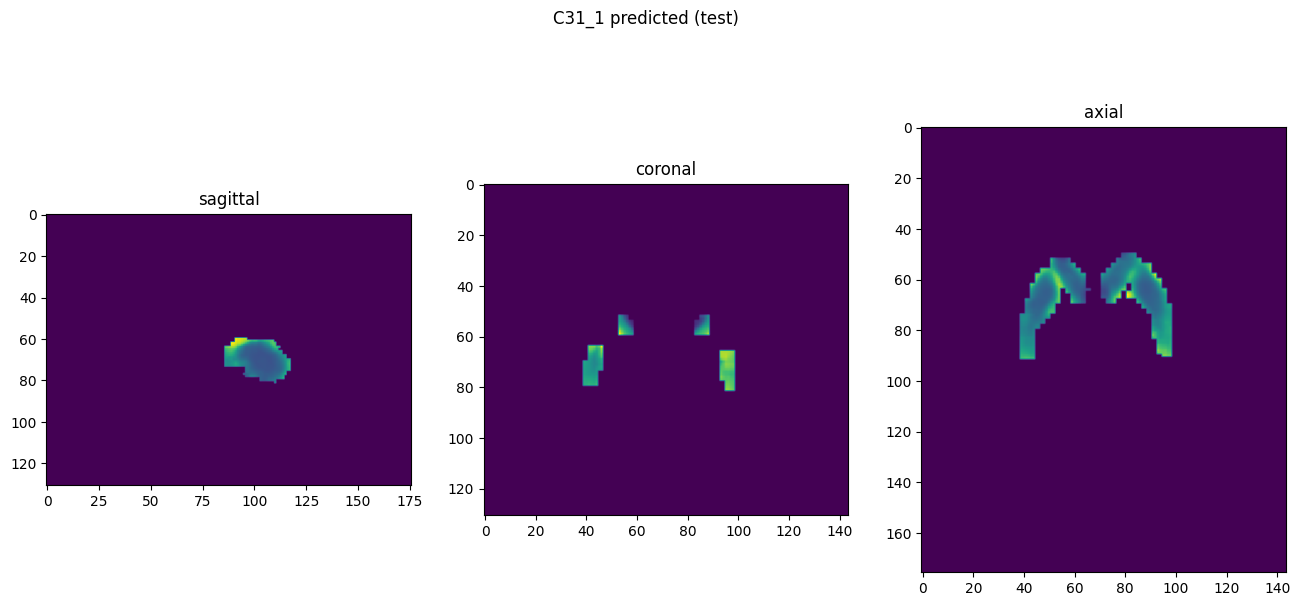

In [10]:
showResults(model, gen, threshold=None, background=False)